# `tf.train.Saver`

* code `02_mnist_cnn_with_slim.ipynb`를 바탕으로 모델 save 및 load (restore)를 해보자.
* [`tf.contrib.slim`](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) 참고

### Import modules

In [1]:
"""A very simple MNIST classifier.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

np.random.seed(219)
tf.set_random_seed(219)

Instructions for updating:
Use the retry module or similar alternatives.


### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

# for fast learning with small dataset
N = 200
train_data = train_data[:N]
train_labels = train_labels[:N]

### Show the MNIST

label = 5


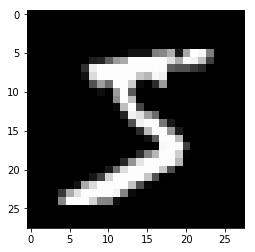

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = 0
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28), cmap='gray')
plt.show()

### Set up dataset with `tf.data`

#### create input pipeline with `tf.data.Dataset`

In [4]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.shuffle(buffer_size = 10000)
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>


#### Define Iterator

In [5]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

### Create the model

In [6]:
def cnn_model_fn(x):
  """Model function for CNN.
  Args:
    x: input images
    mode: boolean whether trainig mode or test mode
    
  Returns:
    logits: unnormalized score funtion
  """
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  # 여기를 직접 채워 넣으시면 됩니다.
  conv1 = slim.conv2d(x_image, 32, [5, 5], scope='conv1')
                      

  # Pooling Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')
  
  # Convolutional Layer #2
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  conv2 = slim.conv2d(pool1, 64, [5, 5], scope='conv2')

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2')

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool2_flat = slim.flatten(pool2, scope='flatten')
  
  # Fully connected Layer
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  # 여기를 직접 채워 넣으시면 됩니다.
  fc1 = slim.fully_connected(pool2_flat, 1024, scope='fc1')

  # Add dropout operation; 0.6 probability that element will be kept
  is_training = tf.placeholder(tf.bool)
  # 여기를 직접 채워 넣으시면 됩니다.
  fc1_drop = slim.dropout(fc1, keep_prob=0.6, is_training=is_training, scope='dropout')

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  # 여기를 직접 채워 넣으시면 됩니다.
  logits = slim.fully_connected(fc1_drop, 10, activation_fn=None, scope='logits')
  
  return logits, is_training, x_image

### Build the model

In [7]:
logits, is_training, x_image = cnn_model_fn(x)

### Define loss and optimizer

In [8]:
# 여기를 직접 채워 넣으시면 됩니다.
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

train_op = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

### Assign `tf.summary.FileWriter`

In [9]:
train_dir = 'graphs/train/'
print('Saving graph to: %s' % train_dir)
train_writer = tf.summary.FileWriter(train_dir)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: graphs/train/


### `tf.summary`

In [10]:
with tf.name_scope('summaries'):
  tf.summary.scalar('loss/cross_entropy', cross_entropy)
  tf.summary.image('images', x_image)
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)
  # merge all summaries
  summary_op = tf.summary.merge_all()

### `tf.train.Saver`

```python
tf.train.Saver.save(sess, save_path, global_step=None...)
tf.train.Saver.restore(sess, save_path)
```

In [11]:
# Create a saver object
saver = tf.train.Saver()

### `tf.Session()` and train

In [16]:
import os 

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [17]:
model_checkpoint_path = '/checkpoint/model/'
mkdir_p(model_checkpoint_path)


sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_initializable_iterator()
train_handle = sess.run(train_iterator.string_handle())

# Train
max_epochs = 6
step = 0
for epochs in range(max_epochs):
  # 여기를 직접 채워 넣으시면 됩니다.
  sess.run(train_iterator.initializer)

  start_time = time.time()
  while True:
    try:
      # 여기를 직접 채워 넣으시면 됩니다.
      saver.save(sess, model_checkpoint_path)
      _, loss = sess.run([train_op, cross_entropy],
                         feed_dict={handle: train_handle,
                                    is_training: True})
      if step % 10 == 0:
        print("step: {}, loss: {}".format(step, loss))
        
        # summary
        summary_str = sess.run(summary_op,
                               feed_dict={handle: train_handle,
                                          is_training: False})
        train_writer.add_summary(summary_str, global_step=step)
        
      step += 1

    except tf.errors.OutOfRangeError:
      print("  End of dataset")  # ==> "End of dataset"
      break

  # Save a model per every one epoch in periodically
  if epochs % 2 == 0:
    print("    Save model at {} epochs".format(epochs))
    saver.save(sess, train_dir + 'model.ckpt', global_step=step)
    
  print("  Epochs: {} Elapsed time: {}".format(epochs, time.time() - start_time))
  print("\n")

train_writer.close()
print("training done!")

step: 0, loss: 2.290534496307373
  End of dataset
    Save model at 0 epochs
  Epochs: 0 Elapsed time: 6.509543418884277


step: 10, loss: 2.1360926628112793
  End of dataset
  Epochs: 1 Elapsed time: 4.718545198440552


  End of dataset
    Save model at 2 epochs
  Epochs: 2 Elapsed time: 5.935460567474365


step: 20, loss: 2.041034698486328
  End of dataset
  Epochs: 3 Elapsed time: 4.810289621353149


step: 30, loss: 1.8288356065750122
  End of dataset
    Save model at 4 epochs
  Epochs: 4 Elapsed time: 5.369690656661987


  End of dataset
  Epochs: 5 Elapsed time: 5.281508922576904


training done!
